# Get WaffleIron Model

In [1]:
from models.waffleiron.segmenter import Segmenter

Using torch.scatter_reduce for 3D to 2D projection.
Using torch.scatter_reduce for 3D to 2D projection.


In [2]:
model = Segmenter(
    input_channels=5,
    feat_channels=768,
    depth=48,
    grid_shape=[[256, 256], [256, 32], [256, 32]],
    nb_class=16, # class for prediction
    #drop_path_prob=config["waffleiron"]["drop_path"],
    layer_norm=True,
)

In [3]:
import torch

# Load pretrained model
ckpt = torch.load('./saved_models/ckpt_last_scalr.pth', map_location="cuda:0")
ckpt = ckpt["net"]

In [4]:
print(ckpt.keys())

dict_keys(['module.embed.norm.weight', 'module.embed.norm.bias', 'module.embed.norm.running_mean', 'module.embed.norm.running_var', 'module.embed.norm.num_batches_tracked', 'module.embed.conv1.weight', 'module.embed.conv1.bias', 'module.embed.conv2.0.weight', 'module.embed.conv2.0.bias', 'module.embed.conv2.0.running_mean', 'module.embed.conv2.0.running_var', 'module.embed.conv2.0.num_batches_tracked', 'module.embed.conv2.1.weight', 'module.embed.conv2.2.weight', 'module.embed.conv2.2.bias', 'module.embed.conv2.2.running_mean', 'module.embed.conv2.2.running_var', 'module.embed.conv2.2.num_batches_tracked', 'module.embed.conv2.4.weight', 'module.embed.final.weight', 'module.embed.final.bias', 'module.waffleiron.channel_mix.0.scale.weight', 'module.waffleiron.channel_mix.0.norm.weight', 'module.waffleiron.channel_mix.0.norm.bias', 'module.waffleiron.channel_mix.0.mlp.0.weight', 'module.waffleiron.channel_mix.0.mlp.0.bias', 'module.waffleiron.channel_mix.0.mlp.2.weight', 'module.waffleiro

In [5]:
new_ckpt = {}
for k in ckpt.keys():
    if k.startswith("module"):
        if k.startswith("module.classif.0"):
            continue
        elif k.startswith("module.classif.1"):
            new_ckpt["classif" + k[len("module.classif.1") :]] = ckpt[k]
        else:
            new_ckpt[k[len("module.") :]] = ckpt[k]
    else:
        new_ckpt[k] = ckpt[k]

In [6]:
new_ckpt.get("classif.weight").shape

torch.Size([16, 768, 1])

In [7]:
model.load_state_dict(new_ckpt)

<All keys matched successfully>

## Model Forward

In [8]:
torch.cuda.set_device("cuda:0")
model = model.cuda("cuda:0")

In [9]:
model.eval()

Segmenter(
  (embed): Embedding(
    (norm): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv1d(5, 768, kernel_size=(1,), stride=(1,))
    (conv2): Sequential(
      (0): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(5, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (final): Conv1d(1536, 768, kernel_size=(1,), stride=(1,))
  )
  (waffleiron): WaffleIron(
    (channel_mix): ModuleList(
      (0): ChannelMix(
        (norm): myLayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
          (1): ReLU(inplace=True)
          (2): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
        )
        (

In [10]:
import torch
import numpy as np
import utils.transforms as tr
from torch.utils.data import Dataset
from scipy.spatial import cKDTree as KDTree
import os
from plyfile import PlyData, PlyElement

class PCDataset(Dataset):
    def __init__(
        self,
        rootdir=None,
        phase="train",
        input_feat="intensity",
        voxel_size=0.1,
        train_augmentations=None,
        dim_proj=[
            0,
        ],
        grids_shape=[(256, 256)],
        fov_xyz=(
            (-1.0, -1.0, -1.0),
            (1.0, 1.0, 1.0),
        ),
        num_neighbors=16,
    ):
        super().__init__()

        # Dataset split
        self.phase = phase
        assert self.phase in ["train", "val", "trainval", "test"]

        # Root directory of dataset
        self.rootdir = rootdir

        # Input features to compute for each point
        self.input_feat = input_feat

        # Downsample input point cloud by small voxelization
        self.downsample = tr.Voxelize(
            dims=(0, 1, 2),
            voxel_size=voxel_size,
            random=(self.phase == "train" or self.phase == "trainval"),
        )

        # Field of view
        assert len(fov_xyz[0]) == len(
            fov_xyz[1]
        ), "Min and Max FOV must have the same length."
        for i, (min, max) in enumerate(zip(*fov_xyz)):
            assert (
                min < max
            ), f"Field of view: min ({min}) < max ({max}) is expected on dimension {i}."
        self.fov_xyz = np.concatenate([np.array(f)[None] for f in fov_xyz], axis=0)
        self.crop_to_fov = tr.Crop(dims=(0, 1, 2), fov=fov_xyz)

        # Grid shape for projection in 2D
        assert len(grids_shape) == len(dim_proj)
        self.dim_proj = dim_proj
        self.grids_shape = [np.array(g) for g in grids_shape]
        self.lut_axis_plane = {0: (1, 2), 1: (0, 2), 2: (0, 1)}

        # Number of neighbors for embedding layer
        assert num_neighbors > 0
        self.num_neighbors = num_neighbors

        # Train time augmentations
        if train_augmentations is not None:
            assert self.phase in ["train", "trainval"]
        self.train_augmentations = train_augmentations
        
        self.list_frames = ["Lille1_1.ply"] # ,  "Lille1_2.ply",  "Lille2.ply",  "Paris.ply",
        self.mean_int = 18.705505
        self.std_int = 23.756725

    def get_occupied_2d_cells(self, pc):
        """Return mapping between 3D point and corresponding 2D cell"""
        cell_ind = []
        for dim, grid in zip(self.dim_proj, self.grids_shape):
            # Get plane of which to project
            dims = self.lut_axis_plane[dim]
            # Compute grid resolution
            res = (self.fov_xyz[1, dims] - self.fov_xyz[0, dims]) / grid[None]
            # Shift and quantize point cloud
            pc_quant = ((pc[:, dims] - self.fov_xyz[0, dims]) / res).astype("int")
            # Check that the point cloud fits on the grid
            min, max = pc_quant.min(0), pc_quant.max(0)
            assert min[0] >= 0 and min[1] >= 0, print(
                "Some points are outside the FOV:", pc[:, :3].min(0), self.fov_xyz
            )
            assert max[0] < grid[0] and max[1] < grid[1], print(
                "Some points are outside the FOV:", pc[:, :3].min(0), self.fov_xyz
            )
            # Transform quantized coordinates to cell indices for projection on 2D plane
            temp = pc_quant[:, 0] * grid[1] + pc_quant[:, 1]
            cell_ind.append(temp[None])
        return np.vstack(cell_ind)

    def prepare_input_features(self, pc_orig):
        # Concatenate desired input features to coordinates
        pc = [pc_orig[:, :3]]  # Initialize with coordinates
        for type in self.input_feat:
            if type == "intensity":
                intensity = pc_orig[:, 3:]
                intensity = (intensity - self.mean_int) / self.std_int
                pc.append(intensity)
            elif type == "height":
                pc.append(pc_orig[:, 2:3])
            elif type == "radius":
                r_xyz = np.linalg.norm(pc_orig[:, :3], axis=1, keepdims=True)
                pc.append(r_xyz)
            elif type == "xyz":
                xyz = pc_orig[:, :3]
                pc.append(xyz)
            elif type == "constant":
                pc.append(np.ones((pc_orig.shape[0], 1)))
            else:
                raise ValueError(f"Unknown feature: {type}")
        return np.concatenate(pc, 1)

    def load_pc(self, index):
        fname = os.path.join(self.rootdir, "training_10_classes", self.list_frames[index])
        print("Loading")
        plydata = PlyData.read(fname)
        x = plydata["vertex"].data["x"].astype(np.float32)
        y = plydata["vertex"].data["y"].astype(np.float32)
        z = plydata["vertex"].data["z"].astype(np.float32)
        z = z - 36
        reflectance = plydata["vertex"].data["reflectance"].astype(np.float32)
        #print(x.shape[0])
        feats = np.zeros((x.shape[0], 1))
        label = plydata["vertex"].data["class"].astype(np.float32)
        #label = label-1
        pts = np.concatenate([
            np.expand_dims(x,1),
            np.expand_dims(y,1),
            np.expand_dims(z,1),
            np.expand_dims(reflectance,1),
            feats,
        ], axis=1).astype(np.float32)
        print("Finished")
        
        return pts, np.expand_dims(label,1), self.list_frames[index]

    def __len__(self):
        return len(self.list_frames)

    def __getitem__(self, index):
        # Load original point cloud
        pc_orig, labels_orig, filename = self.load_pc(index)

        # Prepare input feature
        pc_orig = self.prepare_input_features(pc_orig)

        # Voxelization
        pc, labels = self.downsample(pc_orig, labels_orig)

        # Augment data
        if self.train_augmentations is not None:
            pc, labels = self.train_augmentations(pc, labels)

        # Crop to fov
        pc, labels = self.crop_to_fov(pc, labels)

        # For each point, get index of corresponding 2D cells on projected grid
        cell_ind = self.get_occupied_2d_cells(pc)

        # Get neighbors for point embedding layer providing tokens to waffleiron backbone
        kdtree = KDTree(pc[:, :3])
        assert pc.shape[0] > self.num_neighbors
        dist, neighbors_emb = kdtree.query(pc[:, :3], k=self.num_neighbors + 1)

        # Nearest neighbor interpolation to undo cropping & voxelisation at validation time
        if self.phase in ["train", "trainval"]:
            upsample = np.arange(pc.shape[0])
        else:
            _, upsample = kdtree.query(pc_orig[:, :3], k=1)

        # Output to return
        out = (
            # Point features
            pc[:, 3:].T[None],
            # Point labels of original entire point cloud
            labels if self.phase in ["train", "trainval"] else labels_orig,
            # Projection 2D -> 3D: index of 2D cells for each point
            cell_ind[None],
            # Neighborhood for point embedding layer, which provides tokens to waffleiron backbone
            neighbors_emb.T[None],
            # For interpolation from voxelized & cropped point cloud to original point cloud
            upsample,
            # Filename of original point cloud
            filename,
        )

        return out

In [11]:
class Collate:
    def __init__(self, num_points=None):
        self.num_points = num_points
        assert num_points is None or num_points > 0

    def __call__(self, list_data):

        # Extract all data
        list_of_data = (list(data) for data in zip(*list_data))
        feat, label_orig, cell_ind, neighbors_emb, upsample, filename = list_of_data

        # Zero-pad point clouds
        Nmax = np.max([f.shape[-1] for f in feat])
        if self.num_points is not None:
            assert Nmax <= self.num_points
        occupied_cells = []
        for i in range(len(feat)):
            feat[i], neighbors_emb[i], cell_ind[i], temp = zero_pad(
                feat[i],
                neighbors_emb[i],
                cell_ind[i],
                Nmax if self.num_points is None else self.num_points,
            )
            occupied_cells.append(temp)

        # Concatenate along batch dimension
        feat = torch.from_numpy(np.vstack(feat)).float()  # B x C x Nmax
        neighbors_emb = torch.from_numpy(np.vstack(neighbors_emb)).long()  # B x Nmax
        cell_ind = torch.from_numpy(
            np.vstack(cell_ind)
        ).long()  # B x nb_2d_cells x Nmax
        occupied_cells = torch.from_numpy(np.vstack(occupied_cells)).float()  # B x Nmax
        labels_orig = torch.from_numpy(np.hstack(label_orig)).long()
        upsample = [torch.from_numpy(u) for u in upsample]

        # Prepare output variables
        out = {
            "feat": feat,
            "neighbors_emb": neighbors_emb,
            "upsample": upsample,
            "labels_orig": labels_orig,
            "cell_ind": cell_ind,
            "occupied_cells": occupied_cells,
            "filename": filename,
        }

        return out


In [12]:
def zero_pad(feat, neighbors_emb, cell_ind, Nmax):
    N = feat.shape[-1]
    assert N <= Nmax
    occupied_cells = np.ones((1, Nmax))
    if N < Nmax:
        # Zero-pad with null features
        feat = np.concatenate((feat, np.zeros((1, feat.shape[1], Nmax - N))), axis=2)
        # For zero-padded points, associate last zero-padded points as neighbor
        neighbors_emb = np.concatenate(
            (
                neighbors_emb,
                (Nmax - 1) * np.ones((1, neighbors_emb.shape[1], Nmax - N)),
            ),
            axis=2,
        )
        # Associate zero-padded points to first 2D cell...
        cell_ind = np.concatenate(
            (cell_ind, np.zeros((1, cell_ind.shape[1], Nmax - N))), axis=2
        )
        # ... and at the same time mark zero-padded points as unoccupied
        occupied_cells[:, N:] = 0
    return feat, neighbors_emb, cell_ind, occupied_cells

In [13]:
kwargs = {
        "rootdir": '/root/main/dataset/',
        "input_feat": ["xyz", "intensity"],
        "voxel_size": 0.5,
        "num_neighbors": 32,
        "dim_proj": [2, 1, 0],
        "grids_shape": [[256, 256], [256, 32], [256, 32]],
        "fov_xyz": [[-64, -64, -10], [64, 64, 10]], # Check here
    }

train_dataset = PCDataset(
        phase="val",
        **kwargs,
    )

In [14]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=1,
        pin_memory=True,
        drop_last=True,
        collate_fn=Collate(),
    )

In [15]:
for it, batch in enumerate(train_loader):
    
    if it == 0:

        # Network inputs
        #print(batch["upsample"])
        feat = batch["feat"].cuda(0, non_blocking=True)
        labels = batch["labels_orig"].cuda(0, non_blocking=True)
        batch["upsample"] = [
            up.cuda(0, non_blocking=True) for up in batch["upsample"]
        ]
        cell_ind = batch["cell_ind"].cuda(0, non_blocking=True)
        occupied_cell = batch["occupied_cells"].cuda(0, non_blocking=True)
        neighbors_emb = batch["neighbors_emb"].cuda(0, non_blocking=True)
        net_inputs = (feat, cell_ind, occupied_cell, neighbors_emb)

        with torch.no_grad():
            out = model(*net_inputs)
        
        break
    

Loading
Finished
tensor([[[ 1.0049e+01,  9.0481e+00,  8.9187e+00,  ...,  1.1089e-01,
          -5.5230e+00, -9.5058e-01],
         [-5.2929e+01, -5.0746e+01, -5.0893e+01,  ...,  2.8350e+01,
           2.8913e+01,  2.8476e+01],
         [ 1.1599e+00,  2.5928e+00,  2.2346e+00,  ..., -1.1763e+01,
          -1.1004e+01, -5.4609e+00],
         ...,
         [-1.8681e+02, -1.8602e+02, -1.8686e+02,  ...,  9.5166e+01,
           8.8112e+01,  9.3644e+01],
         [-4.6611e+00, -5.1680e+00, -5.1689e+00,  ...,  2.5810e+00,
           3.6386e+00,  4.3125e+00],
         [-6.9176e+00, -6.4271e+00, -6.2402e+00,  ...,  1.7132e+01,
           1.5623e+01,  1.1076e+01]]], device='cuda:0')
torch.Size([1, 768, 1878])


/home/HyperLiDAR/models/waffleiron/helper_projection.py:32: UserWarning: scatter_reduce() is in beta and the API may change at any time. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1615.)
  include_self=False,


tensor([[[-9.1422e+01, -1.0900e+02, -9.4093e+01,  ...,  4.6501e-02,
           2.4376e+01,  3.8825e+01],
         [-2.6143e+01, -2.7419e+01, -2.9566e+01,  ..., -9.0793e+01,
          -1.6471e+02, -1.1865e+02],
         [-2.6571e+01, -5.5471e+00, -2.2792e+01,  ...,  5.5333e+01,
           8.2744e+01,  7.2795e+01],
         ...,
         [ 2.5103e+02,  2.3928e+02,  2.4985e+02,  ..., -1.4999e+02,
          -1.3057e+02, -1.5791e+02],
         [-9.5130e+01, -9.2589e+01, -9.5435e+01,  ..., -1.6039e+01,
           2.1876e+01, -8.9950e+00],
         [ 6.0435e+01,  5.5213e+01,  6.2486e+01,  ..., -4.9079e+01,
          -3.4421e+01, -5.5955e+01]]], device='cuda:0')
torch.Size([1, 768, 1878])


In [17]:
out, embed, tokens = out[0], out[1], out[2]

In [18]:
labels.shape

torch.Size([30033430, 1])

## Out check

In [136]:
# Voxels to points
out_upsample = []
for id_b, closest_point in enumerate(batch["upsample"]):
    print(id_b)
    print(closest_point)
    temp = out[id_b, :, closest_point]
    out_upsample.append(temp.T)
out_2 = torch.cat(out_upsample, dim=0)

0
tensor([1868, 1868, 1868,  ...,    0,    0,    0], device='cuda:0')


In [137]:
out_2

tensor([[ 390.9475, -348.0847,  -87.7982,  ...,   -0.9795,  297.8709,
           -4.1664],
        [ 390.9475, -348.0847,  -87.7982,  ...,   -0.9795,  297.8709,
           -4.1664],
        [ 390.9475, -348.0847,  -87.7982,  ...,   -0.9795,  297.8709,
           -4.1664],
        ...,
        [-310.8869,  278.1849, -329.1114,  ..., -101.7140,  768.8454,
         -140.5068],
        [-310.8869,  278.1849, -329.1114,  ..., -101.7140,  768.8454,
         -140.5068],
        [-310.8869,  278.1849, -329.1114,  ..., -101.7140,  768.8454,
         -140.5068]], device='cuda:0')

In [138]:
out_2.shape

torch.Size([30033430, 16])

In [139]:
with torch.no_grad():
    nb_class = out_2.shape[1]
    pred_label = out_2.max(1)[1] + 1
    labels = labels[:,0]

In [162]:
print(pred_label.shape)
print(labels.shape)

torch.Size([30033430])
torch.Size([30033430])


In [141]:
print(torch.max(pred_label))

tensor(15, device='cuda:0')


In [142]:
print(torch.min(pred_label))

tensor(1, device='cuda:0')


In [143]:
print(torch.bincount(pred_label))

tensor([       0,  2680048,  2554278,        0,   492562,   582521, 22980276,
               0,        0,   530583,      273,    85557,        0,        0,
               0,   127332], device='cuda:0')


### Npm3D

0 unclassified
1 ground
2 building
3 pole - road sign - traffic light
4 bollard - small pole
5 trash can
6 barrier
7 pedestrian
8 car
9 natural - vegetation

### Nuscenes

0: 'noise'
1: 'barrier'
2: 'bicycle'
3: 'bus'
4: 'car'
5: 'construction_vehicle'
6: 'motorcycle'
7: 'pedestrian'
8: 'traffic_cone'
9: 'trailer'
10: 'truck'
11: 'driveable_surface'
12: 'other_flat'
13: 'sidewalk'
14: 'terrain'
15: 'manmade'
16: 'vegetation'

0 - 0
1 - 11 or 12 or 13 or 14
2 - IGNORE
3 - 8
4 - IGNORE
5 - IGNORE
6 - 1
7 - 7
8 - 2 or 3 or 4 or 5 or 6 or 9 or 10
9 - 16

In [279]:
change = {1:6, 2:8, 3:8, 4:8, 5:8, 6:8, 7:7, 8:3, 9:9, 10:8, 11:1, 12:1, 13:1, 14:1, 15:2, 16:9}

In [270]:
# Everything is being classified as a motorcycle...

In [280]:
from tqdm import tqdm

# Create a lookup table (assuming tensor values are in a known range)
max_key = max(change.keys())  # Find the largest key in the dictionary
lookup_table = torch.zeros(max_key + 1, dtype=torch.long, device=torch.device('cuda'))  # Initialize the lookup table

# Populate the lookup table with the dictionary values
for key, value in tqdm(change.items()):
    lookup_table[key] = value

100%|████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 29879.28it/s]


In [281]:
# Use the lookup table to map the original tensor
mapped_tensor = lookup_table[pred_label]

In [282]:
mapped_tensor

tensor([6, 6, 6,  ..., 8, 8, 8], device='cuda:0')

In [283]:
torch.min(pred_label)

tensor(1, device='cuda:0')

In [284]:
# List of values you want to exclude
from utils.metrics import overall_accuracy, fast_hist

exclude_labels = torch.tensor([0, 2, 4, 5], device=torch.device('cuda'))

where = ~torch.isin(labels, exclude_labels)
confusion_matrix = fast_hist(
    mapped_tensor[where], labels[where], 10
) # pred_label

In [285]:
confusion_matrix
# Label row Pred Columne

tensor([[       0,        0,        0,        0,        0,        0,        0,
                0,        0,        0],
        [       0,    68477,    17812,        0,        0,        0,  1262871,
                0, 15809259,   304449],
        [       0,        0,        0,        0,        0,        0,        0,
                0,        0,        0],
        [       0,        0,        0,        0,        0,        0,     8931,
                0,   153778,     4413],
        [       0,        0,        0,        0,        0,        0,        0,
                0,        0,        0],
        [       0,        0,        0,        0,        0,        0,        0,
                0,        0,        0],
        [       0,        0,        0,        0,        0,        0,    32284,
                0,  1168675,     9569],
        [       0,        0,        0,        0,        0,        0,     3245,
                0,    11429,     1616],
        [       0,    10279,        0,        0,

In [277]:
row_sums = confusion_matrix.sum(dim=1, keepdim=True)  # Sum along rows
confusion_matrix_normalized = confusion_matrix / torch.clamp(row_sums, min=1e-6)  # Avoid division by 0

In [286]:
confusion_matrix_normalized = confusion_matrix / torch.sum(confusion_matrix)

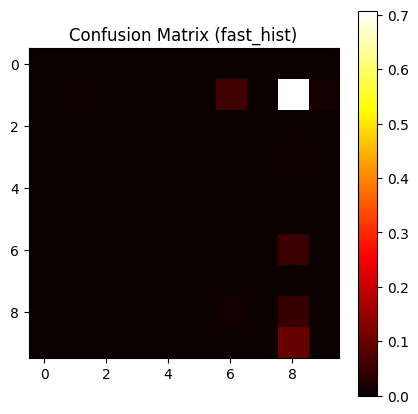

In [287]:
import matplotlib.pyplot as plt

# Option 1: Use matplotlib to visualize the matrix as a heatmap
plt.figure(figsize=(5, 5))
plt.imshow(confusion_matrix_normalized.cpu(), cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar to interpret the values
plt.title('Confusion Matrix (fast_hist)')
plt.savefig('fast_hist_heatmap.png')  # Save the heatmap as an image
plt.show()  # Display the heatmap

In [113]:
torch.cuda.empty_cache()

## Embed check

In [19]:
embed.shape

torch.Size([1, 768, 1878])

In [20]:
labels.shape

torch.Size([30033430, 1])

In [ ]:
# Voxels to points of embed? # HAs very high dimensionality on all points --> Reduce to somesubsample...
embed_upsample = []
for id_b, closest_point in enumerate(batch["upsample"]):
    #print(id_b) # Id of the batch
    #print(closest_point)
    #print(closest_point.shape)
    batch_size = 100
    num_crops = closest_point.shape[0] // batch_size
    for i in range(num_crops):
        start = i * batch_size
        end = start + batch_size
        temp = embed[id_b, :, start:end]
        print(labels[start:end].T)
        embed_upsample.append(temp.T)
        print(embed_upsample)
        x = input("Enter")
#embed_2 = torch.cat(embed_upsample, dim=0)